# Global pipeline for PIZZAIOLO Dataset

OntoClassifier using a YoloV8 model that recognizes toppings, pizza base, and country flags on images. 
The Pizzaiolo dataset can be found here : [https://www.kaggle.com/dsv/8132725](https://www.kaggle.com/dsv/8132725)

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from ultralytics import YOLO

from ontoclassifier import *

from PIL import Image
import matplotlib.pyplot as plt

## Loading ontology

In [2]:
onto_filename = "data/pizzaiolo.xml"
pizza = owlready2.get_ontology(onto_filename).load()

## Global pipeline with Yolov8 Wrapper

In [3]:
# Selecting targeted classes
target_classes = list(pizza.Pizza.descendants())

# otherwise choose only some classes:
# target_classes = [
#     pizza.Napoletana,
#     pizza.CheesyPizza,
#     pizza.VegetarianPizza,
#     pizza.SpicyPizza,
#     pizza.RealItalianPizza,
# ]

In [4]:
# Loading pretrained YoloV8 object detection model
yolo_model = YOLO('data/pizzaiolo-yolov8.pt')

In [5]:
# Mapping YoloV8 outputs to Pizzaïolo Ontology classes
yolo_base_names = dict((k, yolo_model.names[k]) for k in range(1,3))
yolo_topping_names = dict((k, yolo_model.names[k]) for k in range(3,19))
yolo_country_names = dict((k, yolo_model.names[k]) for k in range(19,23))

yolo_base_names, yolo_topping_names, yolo_country_names

({1: 'DeepPanBase', 2: 'ThinAndCrispyBase'},
 {3: 'ParmesanTopping',
  4: 'SlicedTomatoTopping',
  5: 'GreenPepperTopping',
  6: 'OnionTopping',
  7: 'PeperoniSausageTopping',
  8: 'HamTopping',
  9: 'PeperonataTopping',
  10: 'RocketTopping',
  11: 'SpinachTopping',
  12: 'JalapenoPepperTopping',
  13: 'AnchovyTopping',
  14: 'MushroomTopping',
  15: 'PrawnTopping',
  16: 'OliveTopping',
  17: 'SultanaTopping',
  18: 'GarlicTopping'},
 {19: 'America', 20: 'England', 21: 'France', 22: 'Italy'})

In [6]:
# Creating Property Wrappers

hasBase_feature = OntoFeature(pizza.hasBase) 
hasBase_property_wrapper = YoloV8PropertyWrapper(yolo_model, 
                                                    hasBase_feature, 
                                                    yolo_base_names)

hasTopping_feature = OntoFeature(pizza.hasTopping) 
hasTopping_property_wrapper = YoloV8PropertyWrapper(yolo_model, 
                                                    hasTopping_feature, 
                                                    yolo_topping_names)

hasCountry_feature = OntoFeature(pizza.hasCountryOfOrigin)
hasCountry_property_wrapper = YoloV8PropertyWrapper(yolo_model, 
                                                    hasCountry_feature, 
                                                    yolo_country_names)

In [7]:
# Creating the Ontological Feature Extractor
fe_yolo = Yolov8FeaturesExtractor([hasBase_property_wrapper, 
                                   hasTopping_property_wrapper, 
                                   hasCountry_property_wrapper, ])

ontological_extractor = OntologicalExtractor([fe_yolo])

In [8]:
# Creating the OntoClassifier instance
onto_classifier = OntoClassifier(pizza, target_classes, ontological_extractor) #, to_ignore=[pizza.hasBase])

'[ REMOVING  NamedPizza : no property to work with. ]'
'[ REMOVING  Pizza : no property to work with. ]'
Removed :
[pizzaiolo.xml.NamedPizza, pizzaiolo.xml.Pizza]


In [9]:
# Creating the hybrid AI pipeline
pipeline = torch.nn.Sequential(
        ontological_extractor,
        onto_classifier
)

## Inference

In [10]:
from torchvision.io import read_image, ImageReadMode

images = ['data/img_01836.png', 'data/img_00206.png']

img_tensors = []
for img in images:
    img_tensors.append(read_image(img, ImageReadMode.RGB).float())

inputs = torch.stack(img_tensors)


In [11]:
# Classification results
results = pipeline(inputs)
labels = onto_classifier.getTargettedClassesEncoder().inverse_transform(results)
pprint(labels)

[('https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#GenerousPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#Napoletana',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#NonVegetarianPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#RealItalianPizza'),
 ('https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#AmericanHot',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#NonVegetarianPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#RealAmericanPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#SpicyPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#ThickPizza',
  'https://www.univ-littoral.fr/lisic/sysreic/pizzaiolo.xml#VerySpicyPizza')]


In [12]:
# Focusing on a specific image
num = 0

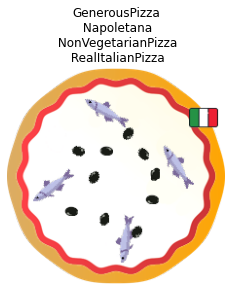

In [13]:
img = Image.open(images[num])

classes = [pizza.search(iri=iri)[0] for iri in labels[num]]
names = [c.name for c in classes]

title = str(names).replace('[', '').replace(']', '').replace('\'', '').replace(',', '\n')
plt.title(title)
plt.axis('off')
plt.imshow(img)

## Explain results

In [14]:
# Instanciating a simple explainer using the OntoClassifier features
explainer = OntologicalExtractorExplainer(ontological_extractor, onto_classifier)

This is NOT a VegetarianPizza because : 
  hasTopping SOME SeafoodTopping is True 
    found 4 AnchovyTopping



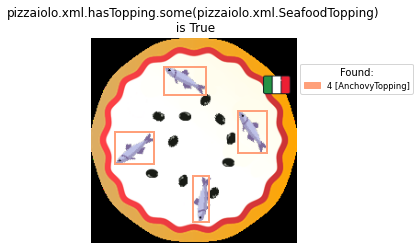

In [15]:
# Explaining why the given image is (NOT ?) classified as a VegetarianPizza
explainer.explain(
    pizza.VegetarianPizza,
    torch.stack([img_tensors[num]])
)